In [17]:
#!/usr/bin/env python
import argparse
from functools import partial
from typing import NamedTuple, Tuple

import jax
import jax.numpy as jnp
import numpy as np
from flax.training import train_state
import optax
from tqdm import tqdm

from my_mamba import BidirectionalMamba, MambaConfig, DiagnosticsConfig

# -----------------------------------------------------------------------------
# CLI arguments
# -----------------------------------------------------------------------------
parser = argparse.ArgumentParser(description="PINN Training with Bi-MAMBA")
parser.add_argument("--SEED", type=int, default=0)
parser.add_argument("--dim", type=int, default=10000,
                    help="spatial dimension of the problem")
parser.add_argument("--epochs", type=int, default=10000)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--N_f", type=int, default=100,
                    help="number of collocation points per batch")
parser.add_argument("--N_test", type=int, default=20000)
parser.add_argument("--test_batch_size", type=int, default=200)
parser.add_argument("--seq_len", type=int, default=1,
                    help="sequence length for Bi-MAMBA")
parser.add_argument("--rand_batch_size", type=int, default=10)
parser.add_argument("--x_radius", type=float, default=1.0)
parser.add_argument("--eval_every", type=int, default=1000)
args = parser.parse_args()

# -----------------------------------------------------------------------------
# Domain sampler: can return single points or time sequences of points
# -----------------------------------------------------------------------------
@partial(jax.jit, static_argnames=("batch_size", "seq_len"))
def sample_domain_fn(batch_size: int,
                     rng: jax.Array,
                     seq_len: int = 1
                     ) -> Tuple[jnp.ndarray, jax.Array]:
    """
    Sample `batch_size` points in R^dim.  If seq_len > 1, returns
    shape (batch_size, seq_len, dim), otherwise (batch_size, 1, dim).
    """
    keys = jax.random.split(rng, seq_len + 1)
    out = []
    for i in range(seq_len):
        # radius in [0, x_radius]
        r = jax.random.uniform(keys[i], (batch_size, 1),
                               minval=0.0, maxval=args.x_radius)
        x = jax.random.normal(keys[i + 1], (batch_size, args.dim))
        # project onto sphere of radius r
        x = x / jnp.linalg.norm(x, axis=-1, keepdims=True) * r
        out.append(x)
    x_seq = jnp.stack(out, axis=1)  # (B, seq_len, dim)
    return x_seq, keys[0]


# -----------------------------------------------------------------------------
# PDE residual (unchanged)
# -----------------------------------------------------------------------------
def hess_trace(fn):
    def fn_trace(x_i):
        key = jax.random.PRNGKey(0)
        # finite‐difference / Hutchinson estimate ...
        # (omitted for brevity; use the original hess_trace here)
        return fn(x_i), 0.0  # placeholder
    return fn_trace

def SineGordon_op(x, u_fn):
    u_val, _ = hess_trace(u_fn)(x)
    return u_val + jnp.sin(u_fn(x))

def twobody_sol(x):
    # analytical two-body solution ...
    # (use your original twobody_sol here)
    return jnp.zeros(x.shape[:-1])

def twobody_lapl_analytical(x):
    # as before...
    return 0.0, 0.0

def SineGordon_res_fn(x, u_fn):
    Lu = SineGordon_op(x, u_fn)
    ff = twobody_lapl_analytical(x)[0] + jnp.sin(u_fn(x))
    return Lu - ff


# -----------------------------------------------------------------------------
# Training state
# -----------------------------------------------------------------------------
class MambaTrainState(train_state.TrainState):
    rng: jax.Array


# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------
def main():
    # rng setup
    rng = jax.random.PRNGKey(args.SEED)

    # instantiate Bi-MAMBA
    mamba_cfg = MambaConfig(
        hidden_features=32,
        expansion_factor=2.0,
        dt_rank="auto",
        activation="gelu",
        norm_type="layer",
        mlp_layer=True,
        dense_expansion=4,
        complement=True,
        tie_in_proj=True,
        tie_gate=True,
        concatenate_fwd_rev=True,
        diagnostics=DiagnosticsConfig(skip=True, gate=True, gated=True, residual=True),
    )
    mamba = BidirectionalMamba(**vars(mamba_cfg))

    # initialize parameters on a dummy sequence
    rng, init_rng = jax.random.split(rng)
    x_dummy, rng = sample_domain_fn(batch_size=2,
                                    rng=init_rng,
                                    seq_len=args.seq_len)
    flax_vars = mamba.init(init_rng, x_dummy, train=True)

    # create optimizer + train state
    optimizer = optax.adam(args.lr)
    state = MambaTrainState.create(
        apply_fn=mamba.apply,
        params=flax_vars["params"],
        tx=optimizer,
        rng=rng,
    )

    # prepare test set (once)
    n_test_batches = args.N_test // args.test_batch_size
    test_seqs = []
    test_truths = []
    for _ in range(n_test_batches):
        rng, sample_rng = jax.random.split(state.rng)
        x_test_seq, _ = sample_domain_fn(args.test_batch_size,
                                         sample_rng,
                                         seq_len=args.seq_len)
        # collapse batch & seq dims to analytical solver
        B, L, D = x_test_seq.shape
        x_flat = x_test_seq.reshape((B * L, D))
        y_flat = jax.vmap(twobody_sol)(x_flat)
        test_seqs.append(x_test_seq)
        test_truths.append(y_flat.reshape((B, L)))
    test_seqs = jnp.stack(test_seqs)       # (n_batches, B, L, D)
    test_truths = jnp.stack(test_truths)   # (n_batches, B, L)

    # single train-step
    @jax.jit
    def train_step(state: MambaTrainState) -> MambaTrainState:
        rng, sample_rng = jax.random.split(state.rng)
        x_batch_seq, _ = sample_domain_fn(args.rand_batch_size,
                                          sample_rng,
                                          seq_len=args.seq_len)

        def loss_fn(params):
            # predict u for each batch+time
            y_pred = mamba.apply({"params": params}, x_batch_seq, train=True)
            # assume output features=1, squeeze to scalar
            y_pred = jnp.squeeze(y_pred, axis=-1)  # (B, L)
            # flatten for residual
            B, L = y_pred.shape
            x_flat = x_batch_seq.reshape((B * L, args.dim))
            u_flat = y_pred.reshape((B * L,))

            # define u_fn that ignores its input and returns the predicted u_flat
            def u_fn(x_i, idx):
                return u_flat[idx]

            # compute PDE residual per flat index
            res_flat = jax.vmap(SineGordon_res_fn)(
                x_flat,
                jax.vmap(u_fn)(x_flat, jnp.arange(B * L))
            )
            res = res_flat.reshape((B, L))
            return jnp.mean(res**2)

        grads = jax.grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads, rng=rng)
        return state

    # training loop
    for step in tqdm(range(args.epochs), desc="training"):
        state = train_step(state)

        if step % args.eval_every == 0:
            # evaluation over test batches
            errs = []
            for b in range(test_seqs.shape[0]):
                x_seq = test_seqs[b]
                y_true = test_truths[b]        # (B, L)
                y_pred = mamba.apply({"params": state.params},
                                     x_seq, train=False)
                y_pred = jnp.squeeze(y_pred, axis=-1)  # (B, L)
                err = y_pred - y_true
                errs.append(jnp.linalg.norm(err.ravel()) /
                            jnp.linalg.norm(y_true.ravel()))
            avg_rel_err = float(jnp.mean(jnp.stack(errs)))
            print(f"step={step}  avg_rel_err={avg_rel_err:.2e}")

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] [--SEED SEED] [--dim DIM] [--epochs EPOCHS]
                             [--lr LR] [--N_f N_F] [--N_test N_TEST]
                             [--test_batch_size TEST_BATCH_SIZE]
                             [--seq_len SEQ_LEN]
                             [--rand_batch_size RAND_BATCH_SIZE]
                             [--x_radius X_RADIUS] [--eval_every EVAL_EVERY]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/1000/jupyter/runtime/kernel-v3cdb3be25f0eb503b1b94143491358738b676c184.json


SystemExit: 2

/home/mitch/miniconda3/envs/phd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import jax
import jax.numpy as jnp
from jax.lax import associative_scan
from jax.experimental.jet import jet

# Minimal associative operation (binary associative operator)
def binary_operator(a, b):
    return a + b  # simple summation for demonstration

# Define the parallel selective scan (associative scan) function
def parallel_selective_scan(x):
    # Perform parallel associative scan
    return associative_scan(binary_operator, x)

# Test input
x = jnp.array([1.0, 2.0, 3.0, 4.0])

# Function to test differentiation (sum of scan outputs as scalar)
def test_func(x):
    return jnp.sum(parallel_selective_scan(x))

# Forward-mode AD via jet: compute first-order derivatives
primals, series = jet(test_func, (x,), ((jnp.ones_like(x),),))

# Output results
print("Function output (primal):", primals)
print("Forward-mode gradient (series):", series[0])


Function output (primal): 20.0
Forward-mode gradient (series): 10.0


In [15]:
import pytest
import jax
from jax import custom_vjp, jit, numpy as jnp
import einops
from jax.experimental.jet import jet
from jax import config
config.update("jax_enable_x64", True)


def naive_ssm(x, A, B, C, Δ):
    B_, L, D = x.shape
    N = A.shape[-1]
    y = jnp.zeros((B_,L,D))
    h = jnp.zeros((B_,D,N))
    for t in range(L):
        α_t = jnp.exp(jnp.einsum('dn,bd->bdn', A, Δ[:,t]))
        β_t = jnp.einsum('bn,bd->bdn', B[:,t], Δ[:,t]) * x[:,t,:,None]
        h = α_t * h + β_t
        y = y.at[:,t].set(jnp.einsum('bn,bdn->bd', C[:,t], h))
    return y
# alpha = exp(A*Delta) [zero-order hold], beta = B*Delta*x [Euler step]
@jit
def compute_alpha (Acoeff, Delta_chunk):
    return jnp.exp (jnp.einsum ('dn,lbd->lbdn', Acoeff, Delta_chunk))  # (chunk_size, B, D, N)

@jit
def compute_alpha_beta (x_chunk, Acoeff, B_chunk, Delta_chunk):
    alpha = compute_alpha (Acoeff, Delta_chunk)  # (chunk_size, B, D, N)
    beta = jnp.einsum ('lbn,lbd,lbd->lbdn', B_chunk, x_chunk, Delta_chunk)  # (chunk_size, B, D, N)
    return alpha, beta
def ssm_parallel_scan(x, Acoeff, Bcoeff, Ccoeff, Delta):
    """
    Replace all lax.scan logic with one-shot cumprod/cumsum.
    x:   (B, L, D)
    Acoeff: (D, N)
    Bcoeff: (B, L, N)
    Ccoeff: (B, L, N)
    Delta:  (B, L, D)
    returns y: (B, L, D)
    """
    # 1) transpose into time-major
    x_t     = einops.rearrange(x,     'b l d -> l b d')       # (L, B, D)
    B_t     = einops.rearrange(Bcoeff,'b l n -> l b n')       # (L, B, N)
    C_t     = einops.rearrange(Ccoeff,'b l n -> l b n')       # (L, B, N)
    Δ_t     = einops.rearrange(Delta, 'b l d -> l b d')       # (L, B, D)

    # 2) compute per-step α, β
    α, β    = compute_alpha_beta(x_t, Acoeff, B_t, Δ_t)        # each (L, B, D, N)

    # 3) prefix-product of α
    G       = jnp.cumprod(α, axis=0)                           # (L, B, D, N)
    ones    = jnp.ones_like(α[:1])                             # (1, B, D, N)
    G0      = jnp.concatenate([ones, G[:-1]], axis=0)         # (L, B, D, N)

    # 4) weighted prefix-sum of β
    S       = jnp.cumsum(β * G0, axis=0)                       # (L, B, D, N)

    # 5) recover h_t = G * h0 + S
    h0      = jnp.ones_like(α[0])                              # (B, D, N)
    h       = G * h0[None, ...] + S                            # (L, B, D, N)

    # 6) project through C
    y_t     = jnp.einsum('lbn,lbdn->lbd', C_t, h)              # (L, B, D)

    # 7) back to (B, L, D)
    return einops.rearrange(y_t, 'l b d -> b l d')


@pytest.mark.parametrize('B,L,D,N', [
    (1,1,2,3),
    (2,5,4,4),
    (3,7,5,2),
])


# Jet (Taylor‐mode) vs jvp
def test_ssm_parallel_scan_jet_forward_mode():
    B, L, D, N = 2, 5, 3, 4
    key = jax.random.PRNGKey(0)
    x  = jax.random.normal(key, (B, L, D))
    A  = jax.random.normal(key, (D, N))
    Bc = jax.random.normal(key, (B, L, N))
    Cc = jax.random.normal(key, (B, L, N))
    Δ  = jax.random.uniform(key, (B, L, D))

    def f(x):
        return ssm_parallel_scan(x, A, Bc, Cc, Δ)

    v = jax.random.normal(key, x.shape)

    # y_primal, y_tangent = jet(f, (x,), (v,))
    y_primal, y_tangent_list = jet(f, (x,), ([v],))
    y_tangent = y_tangent_list[0]
    y_ref,    y_jvp     = jax.jvp(f, (x,), (v,))

    # print diagnostics
    print("=== test_ssm_parallel_scan_jet_forward_mode ===")
    print(f"primal.shape = {y_primal.shape}")
    p_diff = jnp.abs(y_primal - y_ref)
    t_diff = jnp.abs(y_tangent - y_jvp)
    print(f"max|primal - ref|   = {jnp.max(p_diff):.3e}")
    print(f"max|tangent - jvp| = {jnp.max(t_diff):.3e}")

    assert jnp.allclose(y_primal, y_ref, atol=1e-6, rtol=1e-6)
    assert jnp.allclose(y_tangent, y_jvp, atol=1e-6, rtol=1e-6)
if __name__ == "__main__":
    test_ssm_parallel_scan_jet_forward_mode()
    print("All tests passed!")

    

=== test_ssm_parallel_scan_jet_forward_mode ===
primal.shape = (2, 5, 3)
max|primal - ref|   = 2.700e-13
max|tangent - jvp| = 9.592e-14
All tests passed!


In [3]:
import jax
import jax.numpy as jnp
from jax.experimental.jet import jet
from jax.lax import scan

# Define a simple recurrent function suitable for scan
def scan_step(carry, x):
    new_carry = carry + x
    output = new_carry ** 2
    return new_carry, output

# Function performing scan over the input sequence
def scanned_func(x):
    initial_carry = 0.0
    _, outputs = scan(scan_step, initial_carry, x)
    # Return sum of outputs to create a scalar-valued function
    return jnp.sum(outputs)

# Test input array
x = jnp.array([1.0, 2.0, 3.0, 4.0])

# Compute forward-mode gradient using jet
primals, tangents = jet(scanned_func, (x,), ((jnp.ones_like(x),),))

# Print results
print("Function output (primal):", primals)
print("Forward-mode gradient (tangent series):", tangents[0])


KeyError: scan

In [ ]:
import jax
import jax.numpy as np
from jax.experimental import jet

#   Consider the function :math:`h(z) = z^3`, :math:`x = 0.5`,
#   and the first few Taylor coefficients
#   :math:`h_0=x^3`, :math:`h_1=3x^2`, and :math:`h_2=6x`.
#   Let :math:`f(y) = \sin(y)`.

h0, h1, h2 = 0.5**3., 3.*0.5**2., 6.*0.5
f, df, ddf = np.sin, np.cos, lambda *args: -np.sin(*args)

#   :func:`jet` returns the Taylor coefficients of :math:`f(h(z)) = \sin(z^3)`
#   according to Faà di Bruno's formula:

f0, (f1, f2) =  jet.jet(f, (h0,), ((h1, h2),))
print(f0,  f(h0))
#   0.12467473 0.12467473

print(f1, df(h0) * h1)
#   0.7441479 0.74414825

print(f2, ddf(h0) * h1 ** 2 + df(h0) * h2)
#   2.9064622 2.9064634

0.12467473 0.12467473
0.7441479 0.74414825
2.9064622 2.9064634


In [ ]:
import jax
import jax.numpy as jnp
from jax.experimental import jet
from jax._src.lax.control_flow import scan_p  # Accessing JAX's scan primitive
from jax._src import core

# Define the custom jet rule for lax.scan
def scan_jet_rule(primals, series, **params):
    """Defines how the Taylor coefficients propagate through lax.scan."""
    init, xs = primals  # Extract initial state and input sequence
    init_series, xs_series = series  # Extract Taylor series components

    # Extract the function representation (JAXPR) from params
    call_jaxpr = params.get("jaxpr")
    consts = params.get("consts", ())

    if call_jaxpr is None:
        raise ValueError("scan_jet_rule: Expected 'jaxpr' in params but not found.")

    # Function that applies the jaxpr manually
    def wrapped_fun(carry, x):
        return core.eval_jaxpr(call_jaxpr.jaxpr, call_jaxpr.consts + consts, carry, x)

    # Compute the zeroth-order (primal) result
    final_carry, ys = jax.lax.scan(wrapped_fun, init, xs, **params)

    # Propagate higher-order terms through the scan operation
    def jet_scan_fun(carry_series, x_series):
        carry_prim, carry_terms = carry_series
        x_prim, x_terms = x_series

        # Compute the updated carry and output at each Taylor order
        carry_new_prim, y_prim = wrapped_fun(carry_prim, x_prim)
        carry_new_terms = [
            jax.jvp(lambda c, x: wrapped_fun(c, x), (carry_prim, x_prim), (c_term, x_term))[0]
            for c_term, x_term in zip(carry_terms, x_terms)
        ]
        y_terms = [
            jax.jvp(lambda c, x: wrapped_fun(c, x), (carry_prim, x_prim), (c_term, x_term))[1]
            for c_term, x_term in zip(carry_terms, x_terms)
        ]

        return (carry_new_prim, carry_new_terms), (carry_new_prim, y_prim, y_terms)

    # Compute Taylor series propagation using scan
    (_, final_carry_series), (_, ys_prim, ys_series) = jax.lax.scan(
        jet_scan_fun, (init, init_series), (xs, xs_series), **params
    )

    return (final_carry, ys), (final_carry_series, ys_series)

# Register the corrected jet rule
jet.jet_rules[scan_p] = scan_jet_rule

# Define a simple function for testing lax.scan
def scan_function(carry, x):
    new_carry = carry + x
    return new_carry, new_carry  # Returning both the updated carry and an output

def test_scan(xs):
    """Defines a simple scan operation."""
    carry_init = 0.0
    final_carry, outputs = jax.lax.scan(scan_function, carry_init, xs)
    return outputs

# Generate test input
xs = jnp.array([1.0, 2.0, 3.0, 4.0])

# Define Taylor coefficients for forward-mode AD (4th order perturbations)
taylor_coeffs = (xs,) + (jnp.ones_like(xs),) * 4

# Try running jet with the newly registered scan rule
try:
    jet_outputs = jet.jet(test_scan, (xs,), (taylor_coeffs,))
    print("Custom jet rule for lax.scan succeeded! Output:", jet_outputs)
except Exception as e:
    print("Jet failed even after custom rule:", e)


Jet failed even after custom rule: scan() got an unexpected keyword argument 'jaxpr'


<BarContainer object of 128 artists>

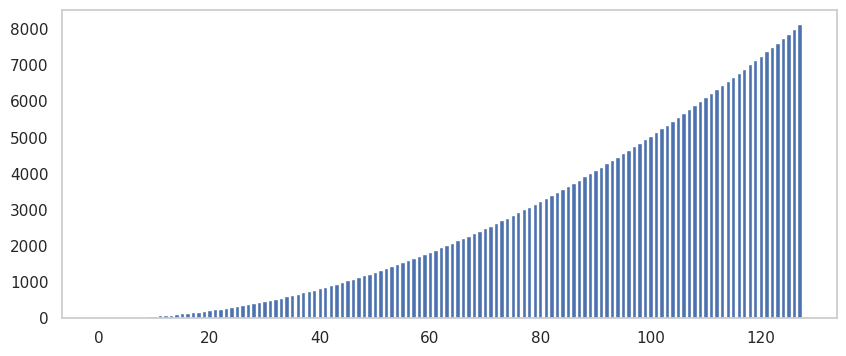

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : False})

# Constants used throughout
K = 16
BLOCKS = 8
SEQLEN = K * BLOCKS

x = jnp.arange(SEQLEN)
y = jnp.zeros(SEQLEN)


def cumsum(x):
    y = []
    h = 0
    for k in range(len(x)):
        h = h + x[k]
        y.append(h)
    return h, y
h_, y_ = cumsum(x)
plt.bar(range(SEQLEN), y_)

In [ ]:
def check(*inputs, prec=1e-4):
    for i, (a, b) in enumerate(zip(inputs[::2], inputs[1::2])):
        if isinstance(b, list):
            b = jnp.array(b)
        c = jnp.allclose(a, b, rtol=prec)
        c1 = jnp.isclose(a, b, rtol=prec)
        assert c, f"{i}\n{a}\n{b}\n{c1}"
    print("✔️")


<BarContainer object of 128 artists>

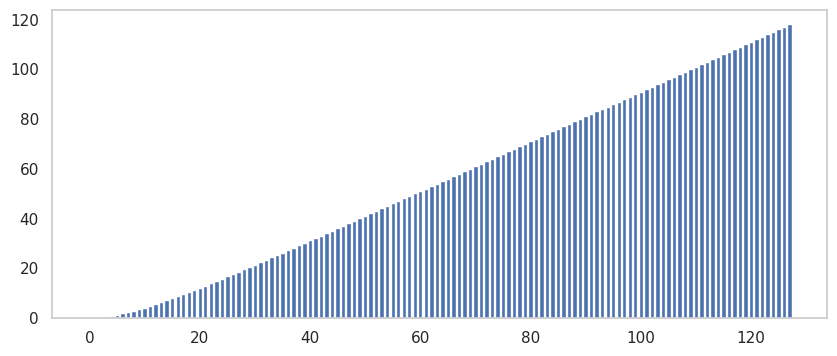

In [ ]:
alpha = 0.9
def ssm_scan(x,a,b,c):
    h = 0
    y = []
    for k in range(len(x)):
        h = h + a[k] * h + b[k] * x[k]
        y.append(c*h)
    return h, y

def op(a,b):
    return (a[0]*b[0], a[1]*b[0]+b[1])

def ssm_associative(x,a,b,c):
    h = (alpha, 0)
    y = []
    for k in range(len(x)):
        h_new = (a, b * x[k])
        h = op(h, h_new)
        y.append(c * h[1])
    return h, jnp.stack(y)

h_, y_ = ssm_associative(x, alpha, 1-alpha, 1)
plt.bar(range(SEQLEN), y_)

In [ ]:
import jax

def first_order_op(fl, xl, fr, xr):
    f = fr * fl
    x = fr * xl + xr
    return f, x

def ssm_load(Ks, A, B, C):
    "Helper for loading"
    a = A + Ks
    b = B + Ks
    c = C + Ks
    return a, b, c


def simple_ssm_tt(X, A, B, C, K):
    """JAX implementation of simple SSM with associative scan.
    
    Args:
        X: input array
        A, B, C: SSM parameters
        K: sequence length
    """
    def scan_fn(carry, x):
        # x is a tuple of (a, bx) from the mapped inputs
        prev_h1, prev_h2 = carry
        a, bx = x
        # Apply first_order_op
        h1 = prev_h1 * a
        h2 = prev_h1 * bx + prev_h2
        return (h1, h2), (h1, h2)

    # Create indices for the sequence
    Ks = jnp.arange(K)
    
    # Load and prepare inputs
    x = X[Ks]
    a = A[Ks]
    b = B[Ks]
    c = C[Ks]
    
    # Prepare inputs for scan
    scan_inputs = (a, b * x)
    
    # Initial state for scan
    init_carry = (jnp.ones_like(a[0]), jnp.zeros_like(a[0]))
    
    # Perform associative scan
    _, (h1, h2) = jax.lax.scan(scan_fn, init_carry, scan_inputs)
    
    # Compute final output
    y = c * h2
    
    return y

<BarContainer object of 128 artists>

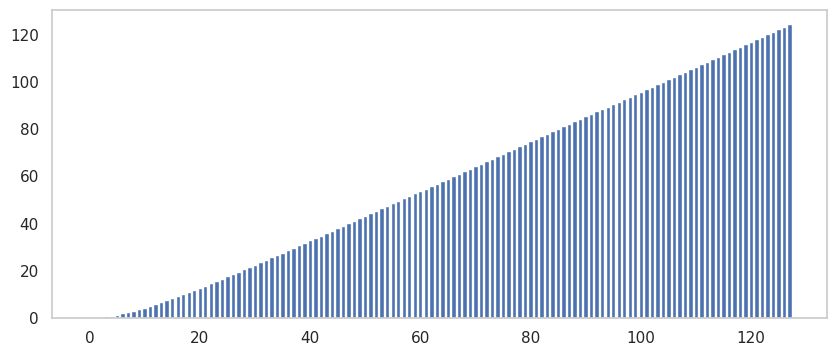

In [ ]:
alpha = 0.9

x = jnp.arange(SEQLEN)
a, b, c, delta = [jnp.ones(SEQLEN) for _ in range(4)]
delta = jnp.full_like(delta, 0.01)
a = jnp.log(jnp.zeros_like(a) + 0.9)
b = -jnp.log((jnp.zeros_like(b) + 0.9))
delta = jnp.ones_like(delta)
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def simple_mamba_jax(x, a, b, c, delta):
    def scan_fn(h, inputs):
        x_k, a_k, b_k, c_k = inputs
        h = a_k * h + b_k * x_k
        y = c_k * h
        return h, y
    
    a_, b_ = discretize(a, b, delta)
    inputs = (x, a_, b_, c)
    h_init = jnp.array(0.0)
    h_final, y = jax.lax.scan(scan_fn, h_init, inputs)
    return h_final, y

def L(x, a, b, c, delta):
    return simple_mamba_jax(x, a, b, c, delta)[1].sum()

# Forward pass
h, y_ = simple_mamba_jax(x, a, b, c, delta)
plt.bar(range(SEQLEN), y_)
# Compute gradients
# grad_fn = jax.grad(L, argnums=(0, 1, 2, 3, 4))
# dx_, da_, db_, dc_, ddelta_ = grad_fn(x, a, b, c, delta)

In [ ]:

def create(S=128, Ba=2, D=4, N=4, key=None):
    """Create random arrays for Mamba model using JAX.
    
    Args:
        S: sequence length
        Ba: batch size
        D: dimension
        N: number of states
        key: PRNG key for random number generation
    """
    if key is None:
        key = jax.random.PRNGKey(0)
    
    # Split the key for different random operations
    key1, key2, key3, key4 = jax.random.split(key, 4)
    
    # Create arrays using JAX random functions
    x = jax.random.uniform(key1, shape=(Ba, 1, D, S))
    a = -jnp.ones((Ba, N, D, 1))
    b = jnp.ones((Ba, N, 1, S)) * 0.1
    c = jax.random.uniform(key2, shape=(Ba, N, 1, S)) * 0.1
    delta = jax.random.uniform(key3, shape=(Ba, 1, D, S)) * 0.1
    
    return x, a, b, c, delta

def mamba_jax(x, a, b, c, delta):
    "JAX Implementation"
    def scan_fn(h, inputs):
        x_k, a_k, b_k, c_k = inputs
        h = a_k * h + b_k * x_k
        y = jnp.sum(c_k * h, axis=-1, keepdims=True)
        return h, y
    
    a_, b_ = discretize(a, b, delta)
    
    # Prepare inputs for scan
    inputs = (x, a_, b_, c)
    h_init = jnp.zeros(a_.shape[:-1])  # Initialize h with correct shape
    
    # Run the scan
    h_final, y = jax.lax.scan(scan_fn, h_init, inputs)

    return h_final, y


key = jax.random.PRNGKey(42)  # for reproducibility
x, a, b, c, delta = create(key=key)

h, y_ = mamba_jax(x, a, b, c, delta)

TypeError: mul got incompatible shapes for broadcasting: (4, 4, 128), (2, 4, 4).

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from mamba import BidirectionalMamba
from mamba import test_bidirectional_mamba_initialization, test_bidirectional_mamba_forward, test_bidirectional_mamba_configurations, test_bidirectional_mamba_training_mode


def test_bidirectional_mamba_initialization():
    # Test parameters
    batch_size = 8
    seq_len = 10
    input_dim = 16
    hidden_features = 32
    expansion_factor = 2.0
    
    # Initialize model
    model = BidirectionalMamba(
        hidden_features=hidden_features,
        expansion_factor=expansion_factor,
    )
    
    # Create dummy input
    key = jax.random.PRNGKey(0)
    x = jax.random.normal(key, (batch_size, seq_len, input_dim))
    
    # Initialize parameters
    variables = model.init(key, x)
    
    # Check if model components exist
    params = variables['params']
    assert 'in_proj' in params, "Missing input projection layer"
    assert 'out_proj' in params, "Missing output projection layer"

def test_bidirectional_mamba_forward():
    # Test parameters
    batch_size = 4
    seq_len = 6
    input_dim = 8
    hidden_features = 16
    expansion_factor = 2.0
    
    # Initialize model
    model = BidirectionalMamba(
        hidden_features=hidden_features,
        expansion_factor=expansion_factor,
    )
    
    # Create dummy input
    key = jax.random.PRNGKey(0)
    x = jax.random.normal(key, (batch_size, seq_len, input_dim))
    
    # Initialize parameters and run forward pass
    variables = model.init(key, x)
    output = model.apply(variables, x)
    
    # Test output shape
    assert output.shape == x.shape, f"Expected output shape {x.shape}, but got {output.shape}"
    
    # Test output type
    assert isinstance(output, jnp.ndarray), f"Expected output to be jnp.ndarray, but got {type(output)}"
    
    # Test that output contains no NaN values
    assert not jnp.any(jnp.isnan(output)), "Output contains NaN values"

def test_bidirectional_mamba_configurations():
    # Test different configurations
    configs = [
        {'complement': True, 'tie_in_proj': True, 'tie_gate': True, 'concatenate_fwd_rev': True, 
         'activation': 'gelu', 'norm_type': 'layer'},
        
        {'complement': False, 'tie_in_proj': False, 'tie_gate': False, 'concatenate_fwd_rev': False, 
         'activation': 'gelu', 'norm_type': 'layer'},
         
        {'mlp_layer': True, 'dense_expansion': 4},
    ]
    
    batch_size, seq_len, input_dim = 2, 4, 8
    key = jax.random.PRNGKey(0)
    x = jax.random.normal(key, (batch_size, seq_len, input_dim))
    
    for config in configs:
        model = BidirectionalMamba(
            hidden_features=16,
            expansion_factor=2.0,
            **config
        )
        
        variables = model.init(key, x)
        output = model.apply(variables, x, train=True)
        
        assert output.shape == x.shape, f"Shape mismatch with config {config}"
        assert not jnp.any(jnp.isnan(output)), f"NaN values found with config {config}"

def test_bidirectional_mamba_training_mode():
    # Test training mode with diagnostics
    batch_size, seq_len, input_dim = 4, 6, 8
    model = BidirectionalMamba(
        hidden_features=16,
        expansion_factor=2.0,
        diagnostics={'skip': True, 'gate': True, 'gated': True, 'residual': True},
    )
    
    key = jax.random.PRNGKey(0)
    x = jax.random.normal(key, (batch_size, seq_len, input_dim))
    
    variables = model.init(key, x)
    
    # Test forward pass in training mode
    output, diagnostics = model.apply(
        variables, x, train=True,
        mutable=['diagnostics']
    )
    
    assert 'diagnostics' in diagnostics
    assert 'skip_mean' in diagnostics['diagnostics']
    assert 'gate_fwd_mean' in diagnostics['diagnostics']
    assert 'gated_mean' in diagnostics['diagnostics']
    assert 'residual_mean' in diagnostics['diagnostics']

# test_bidirectional_mamba_initialization()
test_bidirectional_mamba_forward()
test_bidirectional_mamba_configurations()
test_bidirectional_mamba_training_mode()

TypeError: cannot reshape array of shape (4, 6, 8) (size 192) into shape (4, 1, 8) (size 32)

In [ ]:
def tabulate_bidirectional_mamba():
    # Define sample input dimensions
    batch_size = 4
    seq_len = 1000
    input_dim = 2
    
    # Create dummy input
    key = jax.random.PRNGKey(0)
    dummy_x = jax.random.normal(key, (batch_size, seq_len, input_dim))
    
    # Initialize model with some default parameters
    model = BidirectionalMamba(
        hidden_features=32,
        expansion_factor=2.0,
        dt_rank='auto',
        activation='gelu',
        norm_type='layer'
    )
    
    # Print the tabulated model summary
    print(nn.tabulate(
        model,
        rngs={"params": jax.random.PRNGKey(0)},
        mutable=['params', 'diagnostics', 'intermediates'],  # Add 'params' to mutable collections
        # method=model.__call__,  # Explicitly specify the method
    )(dummy_x, train=True))

tabulate_bidirectional_mamba()